In [1]:
#!pip install requests
#!pip install beautifulsoup4
#!pip install fake_useragent
#!pip install html2text
#!pip install pymorphy2 
#!pip install razdel
#!pip install pymystem3
#!pip install xgboost
#!pip install transformers
#!pip install torch
#!pip install tqdm
#!pip3 install torch torchvision torchaudio
#!pip install simplemma
%pip install tensorflow
%pip install tensorflow-cpu
#!pip install deap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent
import time
from time import sleep
import random
import re
import os
from datetime import datetime, timedelta, timezone
from pymystem3 import Mystem
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
import sqlite3
from simplemma import lemmatize
from ukr_stemmer import UkrainianStemmer
from tree_stem import stem_word
import sqlite3
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout

## Створюємо об'єкт із посиланнями на обрані ЗМІ

In [3]:
# Замініть 'my.db' на ім'я вашої бази даних
db_path = 'my.db'

# З'єднання з базою даних
conn = sqlite3.connect(db_path)

# Зчитування таблиці з бази даних у датафрейм
test_df = pd.read_sql('SELECT * FROM combined_df', conn)

# Закриття з'єднання
conn.close()

In [4]:
test_df

,time,link,title,views,text,popularity_score,cleaned_text,lowercase_text,text_without_stopwords,tree_stemmed,ukrainian_stemmed,lemmatized
0,23:52,https://www.pravda.com.ua/news/2023/12/5/7431812/,"""Знищують усе"": командувач Повітряних сил опри...",38624,Командувач Повітряних сил генерал-лейтенант ...,86.309524,Командувач Повітряних сил генераллейтенант Мик...,командувач повітряних сил генераллейтенант мик...,командувач повітряних сил генераллейтенант мик...,командувач повітрян сил генераллейтенант микол...,командувач повітрян сил генераллейтенант микол...,командувач повітряний сила генераллейтенант Ми...
1,23:36,https://www.pravda.com.ua/news/2023/12/5/7431795/,"Росіяни запустили ""Шахеди"", повітряна тривога ...",27208,Повітряні сили ЗСУ увечері 5 грудня повідоми...,76.488095,Повітряні сили ЗСУ увечері грудня повідомили п...,повітряні сили зсу увечері грудня повідомили п...,повітряні сили зсу увечері грудня повідомили б...,повітрян зс увечер груд повідом бп україн дже...,повітрян сил зсу увечер грудн повідомил бпла у...,повітряний сила зсу увечері грудень повідомити...
2,23:27,https://www.pravda.com.ua/news/2023/12/5/7431811/,"РосЗМІ: російським військовим наказали ""взяти""...",24437,"Російське видання ""Важные истории"" повідомля...",72.619048,Російське видання Важные истории повідомляє що...,російське видання важные истории повідомляє що...,російське видання важные истории повідомляє ро...,російськ виданн важны истори повідомля родич м...,російськ виданн важны истор повідомля родич мо...,російське видання важные истории повідомляти р...
3,22:57,https://www.pravda.com.ua/news/2023/12/5/7431807/,"Україна працює на всіх рівнях, щоб Конгрес США...",2290,Міністр закордонних справ Дмитро Кулеба заяв...,11.011905,Міністр закордонних справ Дмитро Кулеба заявив...,міністр закордонних справ дмитро кулеба заявив...,міністр закордонних дмитро кулеба заявив украї...,міністр закордонн дмитр кулеба заяв україн пра...,міністр закордонн дмитр кулеб заяв україн прац...,міністр закордонний Дмитро Кулеба заявити укра...
4,22:28,https://www.pravda.com.ua/news/2023/12/5/7431803/,"Посилюємо нашу ППО, зокрема на Одещині – Зелен...",6681,Президент України Володимир Зеленський після...,31.845238,Президент України Володимир Зеленський після з...,президент україни володимир зеленський після з...,президент україни володимир зеленський знищенн...,президент україн володимир зеленськ знищенн ро...,президент україн володимир зеленськ знищенн ро...,президент Україна Володимир Зеленський знищенн...
...,...,...,...,...,...,...,...,...,...,...,...,...
828,01:20,https://censor.net/ua/news/3461464/golova_yevr...,Голова європейської дипломатії Боррель планує ...,709,Голова європейської дипломатії Боррель може ві...,2.000000,Голова європейської дипломатії Боррель може ві...,голова європейської дипломатії боррель може ві...,голова європейської дипломатії боррель відвіда...,голов європейськ дипломат боррел відвіда украї...,гол європейськ дипломаті боррел відвід україн ...,голова європейський дипломатія боррель відвіда...
829,00:52,https://censor.net/ua/news/3461462/bolgarskyyi...,Болгарський парламент почав скасування виняткі...,6041,Болгарські законодавці в середу зробили перший...,21.000000,Болгарські законодавці в середу зробили перший...,болгарські законодавці в середу зробили перший...,болгарські законодавці зробили крок скасування...,болгарськ законодав зроб крок скасуванн винят ...,болгарськ законодавц зробил крок скасуванн вин...,болгарський законодавець зробити крок скасуван...
830,00:24,https://censor.net/ua/news/3461461/bayiden_zap...,"Байден запропонував зміни, які підвищують шанс...",6493,Президент США Джо Байден запропонував змінити ...,23.000000,Президент США Джо Байден запропонував змінити ...,президент сша джо байден запропонував змінити ...,президент сша джо байден запропонував змінити ...,президент сш джо байден запропону змін прикорд...,президент сша джо байден запропонув змінит при...,президент сша джо байден запропонувати змінити...
831,23:5

In [5]:
combined_df = test_df.copy()

# Моделі

## Лінійна регресія

In [6]:
def train_and_evaluate_regression_model(df_name, text_column='text', target_column='popularity_score', max_features=1000, test_size=0.2, random_state=42):
    # Завантаження датафрейму за його іменем
    df = globals()[df_name]

    # Використайте TF-IDF для отримання числових ознак з текстових даних
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)  # Оберіть кількість ознак (слів)
    X_tfidf = tfidf_vectorizer.fit_transform(df[text_column]).toarray()

    # Додайте до ознак TF-IDF числові дані
    X = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

    # Одержіть цільову ознаку (popularity_score)
    y = df[target_column]

    # Розділіть дані на тренувальний та тестовий набори
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Ініціалізуйте та навчіть модель лінійної регресії
    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)

    # Зробіть прогнози на тестовому наборі
    y_pred = regression_model.predict(X_test)

    # Оцінка результатів
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Повертаємо дані
    return {
        'model': regression_model,
        'data': text_column,
        'mse': mse,
        'r2': r2
    }

## Дерево рішень

In [7]:
def train_and_evaluate_decision_tree(df_name, text_column='text', target_column='popularity_score', max_features=1000, test_size=0.2, random_state=42):
    # Завантаження датафрейму за його іменем
    df = globals()[df_name]

    # Використайте TF-IDF для отримання числових ознак з текстових даних
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)  # Оберіть кількість ознак (слів)
    X_tfidf = tfidf_vectorizer.fit_transform(df[text_column]).toarray()

    # Додайте до ознак TF-IDF числові дані
    X = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

    # Одержіть цільову ознаку (popularity_score)
    y = df[target_column]

    # Розділіть дані на тренувальний та тестовий набори
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Модель "Дерево рішень"
    decision_tree_model = DecisionTreeRegressor(random_state=random_state)
    decision_tree_model.fit(X_train, y_train)
    y_pred_decision_tree = decision_tree_model.predict(X_test)

    # Оцінка результатів для Дерева рішень
    mse_decision_tree = mean_squared_error(y_test, y_pred_decision_tree)
    r2_decision_tree = r2_score(y_test, y_pred_decision_tree)

    # Повернення значень
    return {
        'model': 'Decision Tree',
        'data': text_column,
        'mse': mse_decision_tree,
        'r2': r2_decision_tree
    }


## Random Forest

In [8]:
def train_and_evaluate_random_forest(df_name, text_column='text', target_column='popularity_score', max_features=1000, test_size=0.2, random_state=42):
    # Завантаження датафрейму за його іменем
    df = globals()[df_name]

    # Використайте TF-IDF для отримання числових ознак з текстових даних
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)  # Оберіть кількість ознак (слів)
    X_tfidf = tfidf_vectorizer.fit_transform(df[text_column]).toarray()

    # Додайте до ознак TF-IDF числові дані
    X = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

    # Одержіть цільову ознаку (popularity_score)
    y = df[target_column]

    # Розділіть дані на тренувальний та тестовий набори
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Модель "Випадковий ліс"
    random_forest_model = RandomForestRegressor(random_state=random_state)
    random_forest_model.fit(X_train, y_train)
    y_pred_random_forest = random_forest_model.predict(X_test)

    # Оцінка результатів для Випадкового лісу
    mse_random_forest = mean_squared_error(y_test, y_pred_random_forest)
    r2_random_forest = r2_score(y_test, y_pred_random_forest)
    
    # Повертання значень
    return {
        'model': 'Random Forest',
        'data': text_column,
        'mse': mse_random_forest,
        'r2': r2_random_forest
    }


## XGBoost

In [9]:
# Оголошуємо змінні поза функцією
xgb_model = None
tfidf_vectorizer = None

def train_and_evaluate_xgboost(df_name, text_column='text', target_column='popularity_score', max_features=1000, test_size=0.2, random_state=42):
    global xgb_model, tfidf_vectorizer  # Дозволяємо змінним з функції впливати на глобальний об'єкт

    # Завантаження датафрейму за його іменем
    df = globals()[df_name]

    # Використайте TF-IDF для отримання числових ознак з текстових даних
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)  # Оберіть кількість ознак (слів)
    X_tfidf = tfidf_vectorizer.fit_transform(df[text_column]).toarray()

    # Додайте до ознак TF-IDF числові дані
    X = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

    # Одержіть цільову ознаку (popularity_score)
    y = df[target_column]

    # Розділіть дані на тренувальний та тестовий набори
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Модель градієнтного бустингу (XGBoost)
    xgb_model = XGBRegressor(random_state=random_state)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    # Оцінка результатів для градієнтного бустингу
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    
    # Повертання значень
    return {
        'model': 'XGBoost',
        'data': text_column,
        'mse': mse_xgb,
        'r2': r2_xgb
    }


## DistilBERT

In [10]:
def train_and_evaluate_distilbert(df_name, text_column='text', target_column='popularity_score', tokenizer_name='distilbert-base-uncased', batch_size=8, learning_rate=1e-5, epochs=5, max_features=1000, test_size=0.2, random_state=42):
    # Завантаження датафрейму за його іменем
    df = globals()[df_name]

    # Розділіть дані на навчальний та тестовий набори
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Визначте клас для датасету
    class MyDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = str(self.texts.iloc[idx])
            label = float(self.labels.iloc[idx])
            encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
            return {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze(), 'label': torch.tensor(label)}

    # Ініціалізуйте токенізатор та модель DistilBERT
    tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)
    model = DistilBertModel.from_pretrained(tokenizer_name)

    # Згенеруйте та обробіть дані для навчання та тестування
    train_dataset = MyDataset(train_df[text_column], train_df[target_column], tokenizer)
    test_dataset = MyDataset(test_df[text_column], test_df[target_column], tokenizer)

    # Визначте модель для задачі регресії
    class Regressor(nn.Module):
        def __init__(self):
            super(Regressor, self).__init__()
            self.bert = model
            self.fc = nn.Linear(768, 1)

        def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0]
            return self.fc(pooled_output)

    # Ініціалізуйте модель, оптимізатор та втрати
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Regressor().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Створіть DataLoader для навчання та тестування
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Тренуйте модель
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}, Loss: {average_loss}')

    # Оцініть модель на тестовому наборі
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Оцініть результат
    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    
    # Повернення значень
    return {
        'model': 'DistilBERT',
        'data': text_column,
        'mse': mse,
        'r2': r2
    }

## RNN

In [23]:
from keras.layers import Dropout

def train_and_evaluate_rnn(df_name, text_column='text', target_column='popularity_score', embedding_dim=50, lstm_units=50, epochs=10, batch_size=32, validation_split=0.2, dropout_rate=0.5, random_state=42):
    # Завантаження датафрейму за його іменем
    df = globals()[df_name]

    # Токенізація текстових даних
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df[text_column])
    total_words = len(tokenizer.word_index) + 1

    # Підготовка даних для моделі RNN
    sequences = tokenizer.texts_to_sequences(df[text_column])
    padded_sequences = pad_sequences(sequences)

    # Одержіть цільову ознаку (popularity_score)
    y = df[target_column]

    # Розділіть дані на тренувальний та тестовий набори
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=random_state)

    # Стандартизація цільової ознаки (популярність)
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten()

    # Побудова моделі RNN
    model = Sequential()
    model.add(Embedding(total_words, embedding_dim, input_length=padded_sequences.shape[1]))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))  # Додавання Dropout
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Навчання моделі
    model.fit(X_train, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    # Оцінка результатів для RNN
    y_pred_rnn_scaled = model.predict(X_test).flatten()
    y_pred_rnn = scaler.inverse_transform(y_pred_rnn_scaled.reshape(-1, 1)).flatten()

    mse_rnn = mean_squared_error(y_test, y_pred_rnn)
    r2_rnn = r2_score(y_test, y_pred_rnn)

    # Повертання значень
    return {
        'model': 'RNN',
        'data': text_column,
        'mse': mse_rnn,
        'r2': r2_rnn
    }

# Використання функції для навчання та оцінки RNN
result_rnn = train_and_evaluate_rnn(df_name='combined_df', text_column='lemmatized', target_column='popularity_score', epochs=5, dropout_rate=0.5)
print(result_rnn)


Epoch 1/50
17/17 [==============================] - 10s 383ms/step - loss: 1.0090 - val_loss: 0.9660
Epoch 2/50
17/17 [==============================] - 5s 299ms/step - loss: 0.9662 - val_loss: 0.9321
Epoch 3/50
17/17 [==============================] - 5s 293ms/step - loss: 0.6606 - val_loss: 0.7772
Epoch 4/50
17/17 [==============================] - 5s 292ms/step - loss: 0.2908 - val_loss: 0.7486
Epoch 5/50
17/17 [==============================] - 5s 299ms/step - loss: 0.1574 - val_loss: 0.7850
Epoch 6/50
17/17 [==============================] - 5s 294ms/step - loss: 0.1305 - val_loss: 0.7524
Epoch 7/50
17/17 [==============================] - 5s 296ms/step - loss: 0.1086 - val_loss: 0.7514
Epoch 8/50
17/17 [==============================] - 5s 296ms/step - loss: 0.1021 - val_loss: 0.7451
Epoch 9/50
17/17 [==============================] - 5s 304ms/step - loss: 0.0940 - val_loss: 0.7235
Epoch 10/50
17/17 [==============================] - 5s 296ms/step - loss: 0.0894 - val_loss: 0.752

## Порівняння моделей

In [12]:
import pandas as pd

def run_models(df_name, text_columns, model_names):
    # Створення словника моделей та їх функцій
    model_functions = {
        'Linear Regression': train_and_evaluate_regression_model,
        'Decision Tree': train_and_evaluate_decision_tree,
        'Random Forest': train_and_evaluate_random_forest,
        'XGBoost': train_and_evaluate_xgboost,
        'DistilBERT': train_and_evaluate_distilbert,
        'RNN': train_and_evaluate_rnn
    }

    # Створення порожнього датафрейму для збереження результатів
    columns = ['model', 'data', 'mse', 'r2']
    models_results_df = pd.DataFrame(columns=columns)

    # Запуск кожної моделі з кожним text_column
    for model_name in model_names:
        if model_name in model_functions:
            model_function = model_functions[model_name]
            for text_column in text_columns:
                result = model_function(df_name=df_name, text_column=text_column)
                result['model'] = model_name
                result['data'] = text_column

                # Додавання результатів до датафрейму
                models_results_df = pd.concat([models_results_df, pd.DataFrame([result], columns=columns)], ignore_index=True)
        else:
            print(f"Warning: Model '{model_name}' not found.")

    return models_results_df

In [13]:
df_name = 'combined_df' 
text_columns = [#'text','cleaned_text','lowercase_text',
    'text_without_stopwords','tree_stemmed','ukrainian_stemmed','lemmatized']

# Перелік моделей
model_names = ['Random Forest', 'XGBoost', 'RNN']#, 'DistilBERT']
#['Linear Regression', 'Decision Tree', 
# Виклик функції та збереження результатів
models_results_df = run_models(df_name, text_columns, model_names)


Epoch 1/10
17/17 [==============================] - 9s 371ms/step - loss: 1.0059 - val_loss: 0.9639
Epoch 2/10
17/17 [==============================] - 5s 309ms/step - loss: 0.9303 - val_loss: 0.9722
Epoch 3/10
17/17 [==============================] - 6s 329ms/step - loss: 0.5288 - val_loss: 0.7931
Epoch 4/10
17/17 [==============================] - 5s 318ms/step - loss: 0.2441 - val_loss: 0.8003
Epoch 5/10
17/17 [==============================] - 5s 316ms/step - loss: 0.1799 - val_loss: 0.8328
Epoch 6/10
17/17 [==============================] - 6s 335ms/step - loss: 0.1299 - val_loss: 0.8349
Epoch 7/10
17/17 [==============================] - 5s 301ms/step - loss: 0.0950 - val_loss: 0.8148
Epoch 8/10
17/17 [==============================] - 5s 301ms/step - loss: 0.0880 - val_loss: 0.8178
Epoch 9/10
17/17 [==============================] - 5s 301ms/step - loss: 0.0830 - val_loss: 0.8196
Epoch 10/10
6/6 [==============================] - 1s 94ms/step
Epoch 1/10
17/17 [==================

In [15]:
# Виведення результатів
models_results_df['r2'] = models_results_df['r2']

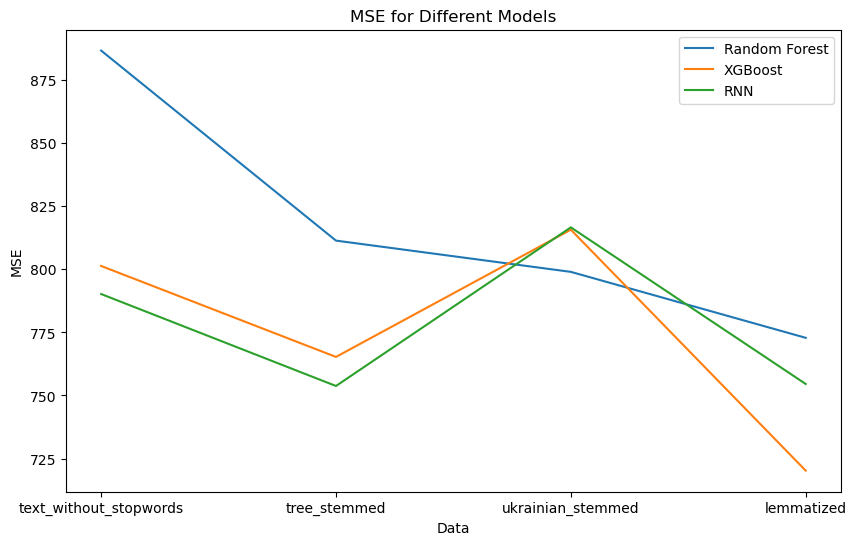

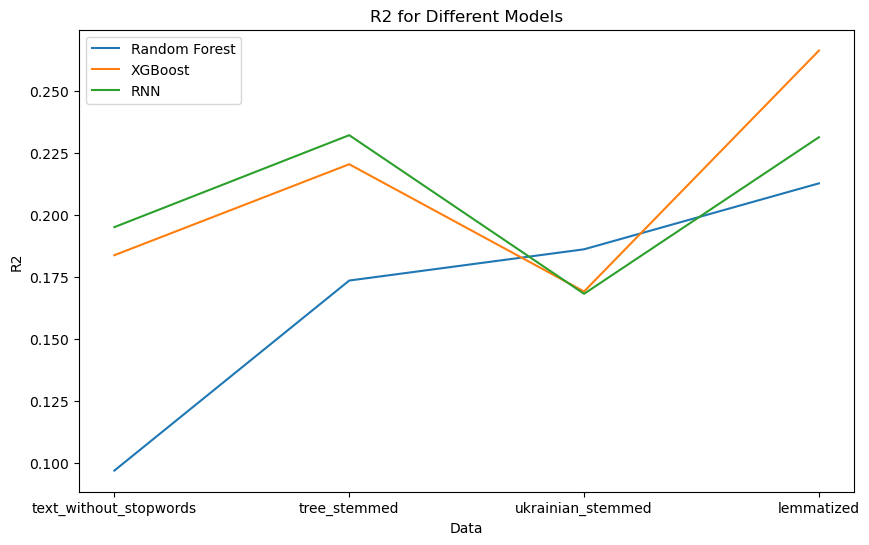

In [16]:
import matplotlib.pyplot as plt

# Побудова графіка MSE для кожної моделі
plt.figure(figsize=(10, 6))
for model in models_results_df['model'].unique():
    model_data = models_results_df[models_results_df['model'] == model]
    plt.plot(model_data['data'], model_data['mse'], label=model)

plt.title('MSE for Different Models')
plt.xlabel('Data')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Побудова графіка R2 для кожної моделі
plt.figure(figsize=(10, 6))
for model in models_results_df['model'].unique():
    model_data = models_results_df[models_results_df['model'] == model]
    plt.plot(model_data['data'], model_data['r2'], label=model)

plt.title('R2 for Different Models')
plt.xlabel('Data')
plt.ylabel('R2')
plt.legend()
plt.show()


## Прогнозування популярності статті

In [17]:
def predict_popularity_score(text):
    if xgb_model is None or tfidf_vectorizer is None:
        raise ValueError("Модель XGBoost та TF-IDF векторизатор не були навчені.")

    # Векторизація введеного тексту за допомогою того ж самого TF-IDF векторизатора
    text_tfidf = tfidf_vectorizer.transform([text]).toarray()

    # Створення DataFrame з числовими ознаками TF-IDF
    text_df = pd.DataFrame(text_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

    # Прогноз popularity_score за допомогою навченої моделі
    predicted_score = xgb_model.predict(text_df)

    return predicted_score[0]

In [18]:
user_input_text = "Пентагон Зеленський розвідка Порошенко Притула"

# Виклик функції для прогнозу popularity_score
predicted_score = predict_popularity_score(user_input_text)

# Виведення результату прогнозу
print(f"Прогнозований popularity_score для введеного тексту: {predicted_score}")

Прогнозований popularity_score для введеного тексту: 44.033447265625


In [19]:
from collections import Counter

def get_top_words_correlated_with_popularity(df_name, text_column='hard_lemmatized_text', max_features=1000, random_state=42):
    global xgb_model, tfidf_vectorizer

    # Завантаження датафрейму за його іменем
    df = globals()[df_name]

    # Використайте TF-IDF для отримання числових ознак з текстових даних
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X_tfidf = tfidf_vectorizer.fit_transform(df[text_column]).toarray()

    # Додайте до ознак TF-IDF числові дані
    X = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

    # Одержіть цільову ознаку (popularity_score)
    y = df['popularity_score']

    # Модель градієнтного бустингу (XGBoost)
    xgb_model = XGBRegressor(random_state=random_state)
    xgb_model.fit(X, y)

    # Отримання важливостей ознак
    feature_importances = xgb_model.feature_importances_

    # Знаходження індексів та назв слів, які найбільше корелюють із успішністю тексту
    top_feature_indices = feature_importances.argsort()[::-1][:max_features]
    top_words = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_feature_indices]

    # Повернення переліку слів та їх важливостей
    return dict(Counter(zip(top_words, feature_importances[top_feature_indices])))

# Приклад виклику функції
top_words_correlated_with_popularity = get_top_words_correlated_with_popularity(df_name='combined_df', text_column='text')
print(top_words_correlated_with_popularity)


{('обстрілів', 0.04985847): 1, ('демократи', 0.029075652): 1, ('європейської', 0.023744706): 1, ('києва', 0.020889468): 1, ('двох', 0.018963072): 1, ('обстріли', 0.018701158): 1, ('знищення', 0.013389761): 1, ('росією', 0.013321306): 1, ('російської', 0.0128496215): 1, ('підтримку', 0.011751199): 1, ('проти', 0.011355954): 1, ('цей', 0.010681552): 1, ('ппо', 0.010605629): 1, ('фронту', 0.010244867): 1, ('відео', 0.010019105): 1, ('мобільного', 0.009458545): 1, ('протягом', 0.009289565): 1, ('поліція', 0.008971286): 1, ('киви', 0.0085089505): 1, ('пункт', 0.008406356): 1, ('повідомленні', 0.008229779): 1, ('збій', 0.008174377): 1, ('територій', 0.007984808): 1, ('лідер', 0.0077456734): 1, ('ситуацію', 0.0072598206): 1, ('тих', 0.007250275): 1, ('щоб', 0.007237906): 1, ('сили', 0.007090366): 1, ('внаслідок', 0.00708642): 1, ('роботи', 0.00706675): 1, ('сенаті', 0.0069095925): 1, ('євро', 0.006877899): 1, ('дані', 0.00683862): 1, ('знайшли', 0.00668693): 1, ('років', 0.006652858): 1, ('уд